In [ ]:
!pip install numpy pandas matplotlib seaborn tensorflow==2.15.0 scikit-learn xgboost scikeras keras-tuner

In [74]:
import os
import pathlib
import numpy as np
import tensorflow as tf
import pandas as pd
import matplotlib.pyplot as plt
import pytz
import matplotlib.dates as mdates
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from scipy.stats.mstats import winsorize
from sklearn.decomposition import PCA, FactorAnalysis
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.feature_selection import RFE
from sklearn.linear_model import LinearRegression
from sklearn.feature_selection import VarianceThreshold
from sklearn.feature_selection import RFE
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import make_scorer
from sklearn.model_selection import GridSearchCV
from tensorflow.keras.layers import LSTM, Dense
from scikeras.wrappers import KerasRegressor
from xgboost import XGBRegressor
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import SimpleRNN, Dense, GRU, Dropout
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
import csv
from google.colab import drive
import io
import re
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import Sequence
from sklearn.model_selection import RandomizedSearchCV
from scikeras.wrappers import KerasRegressor
from tensorflow.keras.layers import LSTM, Dense, BatchNormalization, Dropout
from scipy.stats import uniform, randint
from tensorflow.keras.regularizers import l2
from sklearn.model_selection import ParameterSampler

In [75]:
#Scrapping the data
import requests
import csv
from io import StringIO

url = "https://midcdmz.nrel.gov/apps/plot.pl?site=ORNL;start=20070912;edy=20;emo=11;eyr=2019;year=2017;month=1;day=1;time=1;inst=3;inst=7;inst=8;inst=9;inst=10;inst=11;inst=12;inst=13;inst=14;type=data;first=3;math=0;second=-1;value=0.0;user=0;axis=1;endyear=2017;endmonth=12;endday=31"

response = requests.get(url)

if response.status_code == 200:
    # Parse the response as CSV and save it to a file
    csv_data = response.text
    csv_file = csv.reader(StringIO(csv_data))

    # Specify the path where you want to save the CSV file
    csv_file_path = "output_data.csv"

    # Write the CSV data to the file
    with open(csv_file_path, mode='w', newline='') as file:
        writer = csv.writer(file)
        for row in csv_file:
            writer.writerow(row)

    print(f"Data successfully retrieved and saved to {csv_file_path}")
else:
    print(f"Failed to retrieve data. Status code: {response.status_code}")




Data successfully retrieved and saved to output_data.csv


In [77]:
from google.colab import drive
drive.mount('/content/drive')

file_path = '/content/drive/MyDrive/nrel_solar_irradiance_data_2016_2019_combined.csv'


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [78]:
df = pd.read_csv(file_path);

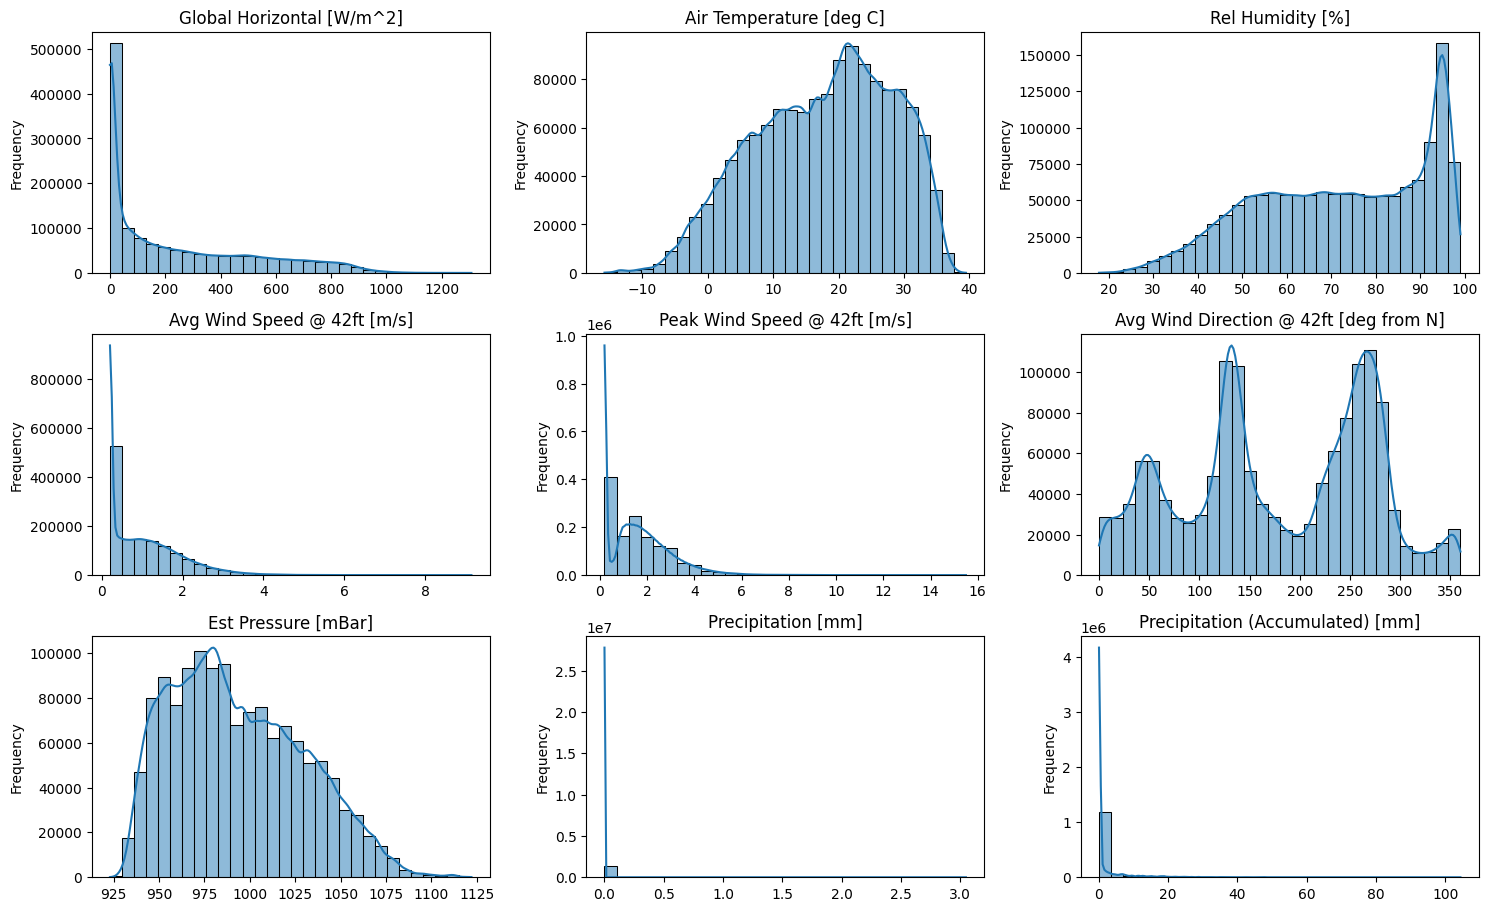

In [79]:
def plot_feature_histograms(df, bins=30):
    """
    Plots histograms for all numeric features in the dataset.
    """
    numeric_cols = df.select_dtypes(include=['number']).columns  # Select only numeric columns

    plt.figure(figsize=(15, 12))  # Set figure size
    for i, col in enumerate(numeric_cols, 1):
        plt.subplot(len(numeric_cols) // 3 + 1, 3, i)  # Create subplots
        sns.histplot(df[col], bins=bins, kde=True)  # Plot histogram with density curve
        plt.title(col)  # Add title
        plt.xlabel("")  # Remove x-labels to avoid clutter
        plt.ylabel("Frequency")

    plt.tight_layout()
    plt.show()


plot_feature_histograms(df)

In [80]:
# Convert the 'DATE (MM/DD/YYYY)' column to datetime format
df['DATE (MM/DD/YYYY)'] = pd.to_datetime(df['DATE (MM/DD/YYYY)'], format="%m/%d/%Y")

# Drop rows with NaN values in the 'EST' column
df.dropna(subset=['EST'], inplace=True)  # Drop rows with NaN values in 'EST'

# Extract hour and minute components from the 'EST' column and create new columns
df[['Hour', 'Minute']] = df['EST'].str.extract('(\d+):(\d+)', expand=True)

# Convert the hour and minute components to integers
df[['Hour', 'Minute']] = df[['Hour', 'Minute']].astype(int)

# Create a timedelta column using the hour and minute components
df['Timedelta'] = pd.to_timedelta(df['Hour'], unit='h') + pd.to_timedelta(df['Minute'], unit='m')

# Combine the date with the timedelta to get a complete datetime
df['Datetime'] = df['DATE (MM/DD/YYYY)'] + df['Timedelta']

# Set the Datetime column as the index
df.set_index('Datetime', inplace=True)

In [ ]:
# Handle negative Global Horizontal values
negative_gh = df[df['Global Horizontal [W/m^2]'] < 0]
print(f"\nNumber of records with negative Global Horizontal: {len(negative_gh)}")

if len(negative_gh) > 0:
    print("\nNegative Global Horizontal records:")
    print(negative_gh)


    # Handle negative values
    # Option 1: Set negative values to 0
    df.loc[df['Global Horizontal [W/m^2]'] < 0, 'Global Horizontal [W/m^2]'] = 0

    # Option 2: Interpolate negative values
    # df.loc[df['Global Horizontal [W/m^2]'] < 0, 'Global Horizontal [W/m^2]'] = np.nan
    # df['Global Horizontal [W/m^2]'] = df['Global Horizontal [W/m^2]'].interpolate()

    print("\nAfter handling negative values:")
    print(f"Number of records with negative Global Horizontal: {len(df[df['Global Horizontal [W/m^2]'] < 0])}")

In [82]:
"""Create new columns Wind_North and Wind_South from the wind direction"""

# Create new columns for binary representation of wind direction
df['Wind_North'] = (df['Avg Wind Direction @ 42ft [deg from N]'] >= 315) | (df['Avg Wind Direction @ 42ft [deg from N]'] < 45)
df['Wind_South'] = (df['Avg Wind Direction @ 42ft [deg from N]'] >= 135) & (df['Avg Wind Direction @ 42ft [deg from N]'] < 225)

# Convert boolean values to 0 and 1
df['Wind_North'] = df['Wind_North'].astype(int)
df['Wind_South'] = df['Wind_South'].astype(int)

#drop the original column.
df.drop('Avg Wind Direction @ 42ft [deg from N]', axis=1, inplace=True)

In [ ]:
# Box plot for Avg Wind Speed @ 42ft [m/s] before winsorization
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
sns.boxplot(data=df, x='Avg Wind Speed @ 42ft [m/s]', color='skyblue')
plt.title('Avg Wind Speed Before Winsorization')

# Box plot for Peak Wind Speed @ 42ft [m/s] before winsorization
plt.subplot(1, 2, 2)
sns.boxplot(data=df, x='Peak Wind Speed @ 42ft [m/s]', color='salmon')
plt.title('Peak Wind Speed Before Winsorization')

plt.tight_layout()
plt.show()

In [84]:
# List of features with outliers to be winsorized
features_with_outliers = ['Avg Wind Speed @ 42ft [m/s]', 'Peak Wind Speed @ 42ft [m/s]']

features_to_normalize = ['Air Temperature [deg C]', 'Rel Humidity [%]', 'Est Pressure [mBar]',
                          'Precipitation [mm]', 'Precipitation (Accumulated) [mm]']

# Apply winsorization to selected features to handle outliers by clipping extreme values.
for feature in features_with_outliers:
    df[feature] = winsorize(df[feature], limits=[0.05, 0.05])

# Apply normalization to scale all features to a similar range (between 0 and 1.)
scaler = MinMaxScaler()
df[features_to_normalize] = scaler.fit_transform(df[features_to_normalize])

# Standardize the mixed-feature dataset
mixed_features = features_with_outliers + features_to_normalize
scaler_standardize = StandardScaler()
df[mixed_features] = scaler_standardize.fit_transform(df[mixed_features])


In [ ]:
# Box plot for Avg Wind Speed @ 42ft [m/s] after winsorization
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
sns.boxplot(data=df, x='Avg Wind Speed @ 42ft [m/s]', color='skyblue')
plt.title('Avg Wind Speed After Winsorization')

# Box plot for Peak Wind Speed @ 42ft [m/s] after winsorization
plt.subplot(1, 2, 2)
sns.boxplot(data=df, x='Peak Wind Speed @ 42ft [m/s]', color='salmon')
plt.title('Peak Wind Speed After Winsorization')

plt.tight_layout()
plt.show()


In [86]:
def create_cyclical_features(df):
    """
    Create cyclical time features from datetime information.
    """
    # Ensure 'DATE (MM/DD/YYYY)' is in datetime format
    df['DATE (MM/DD/YYYY)'] = pd.to_datetime(df['DATE (MM/DD/YYYY)'])

    # Hour features
    df['Hour'] = df['DATE (MM/DD/YYYY)'].dt.hour
    df['Hour_Sin'] = np.sin(df['Hour'] * (2 * np.pi / 24))
    df['Hour_Cos'] = np.cos(df['Hour'] * (2 * np.pi / 24))

    # Day of Year features
    df['DayOfYear'] = df['DATE (MM/DD/YYYY)'].dt.dayofyear
    df['DayOfYear_Sin'] = np.sin((df['DayOfYear'] - 1) * (2 * np.pi / 365))
    df['DayOfYear_Cos'] = np.cos((df['DayOfYear'] - 1) * (2 * np.pi / 365))

    # Month features
    df['Month'] = df['DATE (MM/DD/YYYY)'].dt.month
    df['Month_Sin'] = np.sin((df['Month'] - 1) * (2 * np.pi / 12))
    df['Month_Cos'] = np.cos((df['Month'] - 1) * (2 * np.pi / 12))

    return df

In [87]:
def verify_and_fix_hour_features(df):
    # Check if Hour_Sin and Hour_Cos exist
    if 'Hour_Sin' not in df.columns or 'Hour_Cos' not in df.columns:
        print("Hour_Sin or Hour_Cos not found. Creating these features...")

        # Ensure Hour is present and is the correct type
        if 'Hour' not in df.columns:
            print("Hour column not found. Extracting hour from DATE column...")
            df['Hour'] = df['DATE (MM/DD/YYYY)'].dt.hour

        # Convert Hour to float to ensure correct calculations
        df['Hour'] = df['Hour'].astype(float)

        # Create Hour_Sin and Hour_Cos
        df['Hour_Sin'] = np.sin(df['Hour'] * (2 * np.pi / 24))
        df['Hour_Cos'] = np.cos(df['Hour'] * (2 * np.pi / 24))
    else:
        print("Hour_Sin and Hour_Cos found. Verifying calculations...")
        # Recalculate to ensure correctness
        df['Hour_Sin'] = np.sin(df['Hour'].astype(float) * (2 * np.pi / 24))
        df['Hour_Cos'] = np.cos(df['Hour'].astype(float) * (2 * np.pi / 24))

    # Verify the columns exist and have correct data
    print("\nColumn info after verification/fix:")
    for col in ['Hour', 'Hour_Sin', 'Hour_Cos']:
        print(f"{col}: {df[col].dtype}, Range: [{df[col].min()}, {df[col].max()}]")

    return df

# Use the function
df = verify_and_fix_hour_features(df)



Hour_Sin or Hour_Cos not found. Creating these features...

Column info after verification/fix:
Hour: float64, Range: [4.0, 20.0]
Hour_Sin: float64, Range: [-1.0, 1.0]
Hour_Cos: float64, Range: [-1.0, 0.5000000000000001]


In [ ]:

def create_correlation_matrix(df, target_column='Global Horizontal [W/m^2]'):
    """
    Create and visualize a correlation matrix for all features including the target variable.
    """
    # Select numeric columns
    numeric_columns = df.select_dtypes(include=[np.number]).columns.tolist()

    # Add Hour, Hour_Sin, Hour_Cos if they exist
    for col in ['Hour', 'Hour_Sin', 'Hour_Cos']:
        if col in df.columns and col not in numeric_columns:
            numeric_columns.append(col)

    numeric_df = df[numeric_columns]

    # Compute the correlation matrix
    corr_matrix = numeric_df.corr()

    # Create a heatmap of the correlation matrix
    plt.figure(figsize=(16, 14))
    mask = np.triu(np.ones_like(corr_matrix, dtype=bool))
    sns.heatmap(corr_matrix,
                mask=mask,
                annot=True,
                fmt=".2f",
                cmap='RdBu_r',
                vmin=-1,
                vmax=1,
                center=0,
                square=True,
                linewidths=0.5,
                cbar_kws={"shrink": .8})

    plt.title('Correlation Matrix Heatmap', fontsize=16, pad=20)
    plt.tight_layout()
    plt.show()

    # Print correlations with the target variable
    target_correlations = corr_matrix[target_column].sort_values(ascending=False)
    print("\nCorrelations with target variable (Global Horizontal [W/m^2]):")
    print(target_correlations)

    # Print specific correlations for Hour-related features if they exist
    hour_features = [col for col in ['Hour', 'Hour_Sin', 'Hour_Cos'] if col in corr_matrix.columns]
    if hour_features:
        print("\nCorrelations for Hour-related features:")
        hour_correlations = target_correlations[hour_features]
        print(hour_correlations)

    return corr_matrix

# Use the function
corr_matrix = create_correlation_matrix(df)

# Print the shape of the correlation matrix to verify all features are included
print(f"\nShape of correlation matrix: {corr_matrix.shape}")

# Print the column names used in the correlation matrix
print("\nColumns used in correlation matrix:")
print(corr_matrix.columns.tolist())

In [ ]:
# def plot_hour_cos_vs_ghi(df):
#     plt.figure(figsize=(12, 8))

#     # Create a scatter plot with color indicating point density
#     sns.scatterplot(x='Hour_Cos', y='Global Horizontal [W/m^2]', data=df,
#                     alpha=0.1, color='blue', edgecolor=None)

#     # Add a trend line using numpy's polyfit
#     z = np.polyfit(df['Hour_Cos'], df['Global Horizontal [W/m^2]'], 2)
#     p = np.poly1d(z)
#     plt.plot(df['Hour_Cos'], p(df['Hour_Cos']), "r--", linewidth=2)

#     # Customize the plot
#     plt.title('Global Horizontal Irradiance vs Hour_Cos', fontsize=16)
#     plt.xlabel('Hour_Cos', fontsize=14)
#     plt.ylabel('Global Horizontal Irradiance [W/m^2]', fontsize=14)
#     plt.grid(True, linestyle='--', alpha=0.7)

#     # Add text explaining Hour_Cos values
#     plt.text(0.95, 0.95, 'Hour_Cos ≈ -1: Noon\nHour_Cos ≈ 0: 6 AM/6 PM\nHour_Cos ≈ 1: Midnight',
#              transform=plt.gca().transAxes, verticalalignment='top',
#              horizontalalignment='right', bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))

#     # Add correlation coefficient to the plot
#     correlation = df['Hour_Cos'].corr(df['Global Horizontal [W/m^2]'])
#     plt.text(0.05, 0.95, f'Correlation: {correlation:.3f}',
#              transform=plt.gca().transAxes, verticalalignment='top',
#              horizontalalignment='left', bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))

#     plt.tight_layout()
#     plt.show()

# # Assuming your dataframe is named 'df'
# plot_hour_cos_vs_ghi(df)

In [ ]:
from scipy import stats

def analyze_wind_speed_correlation(df):
    # Calculate correlation between Peak and Avg Wind Speed
    correlation = df['Peak Wind Speed @ 42ft [m/s]'].corr(df['Avg Wind Speed @ 42ft [m/s]'])

    # Calculate correlations with the target variable
    target_corr = df[['Peak Wind Speed @ 42ft [m/s]', 'Avg Wind Speed @ 42ft [m/s]', 'Global Horizontal [W/m^2]']].corr()['Global Horizontal [W/m^2]']

    # Create a scatter plot with hex bins to handle overplotting
    plt.figure(figsize=(12, 8))

    # Hexbin plot
    plt.hexbin(df['Avg Wind Speed @ 42ft [m/s]'], df['Peak Wind Speed @ 42ft [m/s]'],
               gridsize=30, cmap='Blues')

    # Add color bar
    cb = plt.colorbar()
    cb.set_label('Count')

    # Add regression line
    x = df['Avg Wind Speed @ 42ft [m/s]']
    y = df['Peak Wind Speed @ 42ft [m/s]']
    slope, intercept, r_value, p_value, std_err = stats.linregress(x, y)
    line = slope * x + intercept
    plt.plot(x, line, color='red', lw=2, label=f'Regression line (R² = {r_value**2:.4f})')

    # Plot settings
    plt.title('Peak Wind Speed vs Average Wind Speed', fontsize=16)
    plt.xlabel('Average Wind Speed [m/s]', fontsize=12)
    plt.ylabel('Peak Wind Speed [m/s]', fontsize=12)

    # Add diagonal line for reference
    max_val = max(df['Peak Wind Speed @ 42ft [m/s]'].max(), df['Avg Wind Speed @ 42ft [m/s]'].max())
    plt.plot([0, max_val], [0, max_val], 'g--', label='y=x')

    # Add text annotations
    plt.text(0.05, 0.95, f'Correlation: {correlation:.4f}', transform=plt.gca().transAxes,
             fontsize=10, verticalalignment='top')
    plt.text(0.05, 0.90, f'Corr with GHI (Peak): {target_corr["Peak Wind Speed @ 42ft [m/s]"]:.4f}',
             transform=plt.gca().transAxes, fontsize=10, verticalalignment='top')
    plt.text(0.05, 0.85, f'Corr with GHI (Avg): {target_corr["Avg Wind Speed @ 42ft [m/s]"]:.4f}',
             transform=plt.gca().transAxes, fontsize=10, verticalalignment='top')

    plt.legend()
    plt.tight_layout()
    plt.show()

# Assuming your dataframe is named 'df'
analyze_wind_speed_correlation(df)

In [ ]:
def select_features(df):
    # Features to definitely keep
    features_to_keep = [
        'Global Horizontal [W/m^2]',  # Target variable
        'Air Temperature [deg C]',
        'Peak Wind Speed @ 42ft [m/s]',
        'Avg Wind Speed @ 42ft [m/s]',
        'Est Pressure [mBar]',
        'Rel Humidity [%]',
        'Hour_Cos'
    ]

    # Features to consider keeping (we'll keep them for now, but you can experiment later)
    features_to_consider = [
        'Hour_Sin',
        'Wind_North',
        'Precipitation [mm]',
        'Precipitation (Accumulated) [mm]',

    ]

    # Combine all features we want to keep
    all_features_to_keep = features_to_keep + features_to_consider

    # Create a new dataframe with only the selected features
    df_selected = df[all_features_to_keep].copy()

    # Print information about dropped and kept features
    print("Features dropped:")
    print(set(df.columns) - set(all_features_to_keep))

    print("\nFeatures kept:")
    print(df_selected.columns.tolist())

    print(f"\nOriginal dataframe shape: {df.shape}")
    print(f"New dataframe shape: {df_selected.shape}")

    return df_selected

# Assuming your original dataframe is named 'df'
df_selected = select_features(df)

# If you want to save the new dataframe to a CSV file
# df_selected.to_csv('solar_irradiance_selected_features.csv', index=False)

In [ ]:
def split_and_scale_data(df, target_column='Global Horizontal [W/m^2]'):
    """
    Split the data into train (2016-2018) and test (2019) sets,
    scale the numeric feature columns, and retain datetime information.
    """
    # Ensure the dataframe has a datetime index
    if not isinstance(df.index, pd.DatetimeIndex):
        df['DATE (MM/DD/YYYY)'] = pd.to_datetime(df['DATE (MM/DD/YYYY)'])
        df.set_index('DATE (MM/DD/YYYY)', inplace=True)

    # Split into features (X) and target (y)
    X = df.drop(columns=[target_column])
    y = df[target_column]

    # Split into train (2016-2018) and test (2019) sets
    X_train = X[X.index.year < 2019]
    X_test = X[X.index.year == 2019]
    y_train = y[y.index.year < 2019]
    y_test = y[y.index.year == 2019]

    # Initialize the scaler
    scaler = StandardScaler()

    # Separate numeric and non-numeric columns
    numeric_cols = X_train.select_dtypes(include=[np.number]).columns
    non_numeric_cols = X_train.select_dtypes(exclude=[np.number]).columns

    # Handle timedelta columns
    for col in numeric_cols:
        if pd.api.types.is_timedelta64_dtype(X_train[col]):
            X_train[col] = X_train[col].dt.total_seconds()
            X_test[col] = X_test[col].dt.total_seconds()

    # Fit the scaler on the numeric training data
    scaler.fit(X_train[numeric_cols])

    # Transform numeric columns
    X_train_scaled = pd.DataFrame(scaler.transform(X_train[numeric_cols]),
                                  columns=numeric_cols, index=X_train.index)
    X_test_scaled = pd.DataFrame(scaler.transform(X_test[numeric_cols]),
                                 columns=numeric_cols, index=X_test.index)

    # Add non-numeric columns back
    for col in non_numeric_cols:
        X_train_scaled[col] = X_train[col]
        X_test_scaled[col] = X_test[col]

    print(f"Training set shape: {X_train_scaled.shape}")
    print(f"Test set shape: {X_test_scaled.shape}")

    return X_train_scaled, X_test_scaled, y_train, y_test, scaler

# Use the function
X_train_scaled, X_test_scaled, y_train, y_test, scaler = split_and_scale_data(df)

# Print column information
print("\nColumns in scaled data:")
print(X_train_scaled.columns.tolist())

# Check for any remaining issues
print("\nData types in scaled training data:")
print(X_train_scaled.dtypes)

# Verify scaling for numeric columns
numeric_cols = X_train_scaled.select_dtypes(include=[np.number]).columns
print("\nMean and standard deviation of scaled numeric features:")
print(X_train_scaled[numeric_cols].mean())
print(X_train_scaled[numeric_cols].std())

# Print information about non-numeric columns
non_numeric_cols = X_train_scaled.select_dtypes(exclude=[np.number]).columns
print("\nNon-numeric columns retained:")
print(non_numeric_cols.tolist())

In [ ]:
def time_to_decimal(time_str):
    hours, minutes = map(int, time_str.split(':'))
    return hours + minutes / 60.0

# Convert 'EST' to decimal hours
if 'EST' in X_train_scaled.columns:
    X_train_scaled['EST'] = X_train_scaled['EST'].apply(time_to_decimal)
    X_test_scaled['EST'] = X_test_scaled['EST'].apply(time_to_decimal)

# Convert datetime column to a numeric representation (timestamp)
if 'DATE (MM/DD/YYYY)' in X_train_scaled.columns:
    X_train_scaled['DATE (MM/DD/YYYY)'] = pd.to_datetime(X_train_scaled['DATE (MM/DD/YYYY)']).astype(int) / 10**9
    X_test_scaled['DATE (MM/DD/YYYY)'] = pd.to_datetime(X_test_scaled['DATE (MM/DD/YYYY)']).astype(int) / 10**9

# Ensure all columns are numeric
X_train_scaled = X_train_scaled.apply(pd.to_numeric, errors='coerce')
X_test_scaled = X_test_scaled.apply(pd.to_numeric, errors='coerce')

# Check for any remaining non-numeric columns
non_numeric_columns = X_train_scaled.select_dtypes(exclude=[np.number]).columns
print("Non-numeric columns after conversion:")
print(non_numeric_columns)

# Check for NaN values
print("\nNaN values in X_train_scaled:")
print(X_train_scaled.isna().sum())

print("\nNaN values in y_train:")
print(pd.isna(y_train).sum())

# If there are NaN values, you might want to handle them
X_train_scaled = X_train_scaled.fillna(X_train_scaled.mean())
X_test_scaled = X_test_scaled.fillna(X_test_scaled.mean())
y_train = y_train.fillna(y_train.mean())
y_test = y_test.fillna(y_test.mean())

# Verify data types again
print("\nUpdated data types:")
print(X_train_scaled.dtypes)
print(y_train.dtype)

# Final check for NaN values
print("\nFinal check for NaN values in X_train_scaled:")
print(np.any(np.isnan(X_train_scaled)))
print("\nFinal check for NaN values in y_train:")
print(np.any(np.isnan(y_train)))

In [94]:
#drop avg wind speed
X_train_scaled.drop(columns=['Avg Wind Speed @ 42ft [m/s]'], inplace=True)
X_test_scaled.drop(columns=['Avg Wind Speed @ 42ft [m/s]'], inplace=True)

# RANDOM SEARCH

In [ ]:
# from tqdm import tqdm
# import time


# class TimeSeriesGenerator(tf.keras.utils.Sequence):
#     def __init__(self, X, y, time_steps, batch_size):
#         self.X, self.y = X, y
#         self.time_steps = time_steps
#         self.batch_size = batch_size
#         self.indexes = np.arange(len(X) - time_steps)

#     def __len__(self):
#         return (len(self.indexes) - 1) // self.batch_size + 1

#     def __getitem__(self, index):
#         start = index * self.batch_size
#         end = min((index + 1) * self.batch_size, len(self.indexes))
#         X_batch = np.array([self.X[i:i+self.time_steps] for i in self.indexes[start:end]])
#         y_batch = np.array([self.y[i+self.time_steps] for i in self.indexes[start:end]])
#         return X_batch, y_batch

# def create_model(lstm_units, dropout_rate, learning_rate, time_steps, n_features):
#     model = Sequential([
#         LSTM(lstm_units, return_sequences=True, input_shape=(time_steps, n_features)),
#         BatchNormalization(),
#         Dropout(dropout_rate),
#         LSTM(lstm_units // 2),
#         BatchNormalization(),
#         Dropout(dropout_rate),
#         Dense(1)
#     ])
#     model.compile(optimizer=Adam(learning_rate=learning_rate), loss='mse')
#     return model

# # Use a subset of data for hyperparameter tuning
# subset_fraction = 0.2  # Use 20% of data for tuning
# X_train_subset, _, y_train_subset, _ = train_test_split(X_train_scaled, y_train, test_size=1-subset_fraction, random_state=42)

# # Define the parameter space (reduced range and options)
# param_dist = {
#     'lstm_units': randint(15, 128),  # Reduced upper bound
#     'dropout_rate': uniform(0.1, 0.3),  # Narrower range
#     'learning_rate': uniform(0.0005, 0.005),  # Narrower range
#     'batch_size': randint(32, 64),  # Smaller batch sizes
#     'epochs': randint(10, 20),  # Fewer epochs
#     'time_steps': [3, 5, 7]  # Fewer options
# }

# n_features = X_train_subset.shape[1]

# # Random search (reduced number of iterations)
# n_iter = 1  # Reduced from 10 to 5

# param_list = list(ParameterSampler(param_dist, n_iter=n_iter, random_state=42))

# best_score = float('inf')
# best_params = None

# print("Starting random search...")
# for i, params in enumerate(param_list):
#     print(f"\nTrial {i+1}/{n_iter}")
#     print(f"Parameters: {params}")

#     model = create_model(params['lstm_units'], params['dropout_rate'],
#                          params['learning_rate'], params['time_steps'], n_features)

#     train_gen = TimeSeriesGenerator(X_train_subset, y_train_subset,
#                                     params['time_steps'], params['batch_size'])
#     val_gen = TimeSeriesGenerator(X_test_scaled, y_test,
#                                   params['time_steps'], params['batch_size'])

#     history = model.fit(train_gen, epochs=params['epochs'],
#                         validation_data=val_gen, verbose=1)

#     val_loss = history.history['val_loss'][-1]
#     print(f"Validation Loss: {val_loss}")

#     if val_loss < best_score:
#         best_score = val_loss
#         best_params = params

# print("\nRandom search completed")
# print(f"Best parameters: {best_params}")
# print(f'The best score of the validation is {best_score}')


In [97]:
from sklearn.neighbors import KNeighborsRegressor

def random_search_knn(X_train, y_train, n_iter=20, cv=3):
    param_dist = {
        'n_neighbors': range(1, 20),
        'weights': ['uniform', 'distance'],
        'metric': ['euclidean', 'manhattan']
    }

    knn = KNeighborsRegressor()
    random_search = RandomizedSearchCV(knn, param_dist, n_iter=n_iter, cv=cv, scoring='neg_mean_squared_error', random_state=42, n_jobs=-1)
    random_search.fit(X_train, y_train)

    return random_search.best_estimator_

# Train KNN with best params
best_knn = random_search_knn(X_train_scaled, y_train)
knn_predictions = best_knn.predict(X_test_scaled)

In [99]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import numpy as np

# Function to calculate evaluation metrics
def evaluate_model(y_test, y_pred, model_name):
    mse = mean_squared_error(y_test, y_pred)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    nrmse = rmse / (y_test.max() - y_test.min())  # Normalized RMSE

    return {
        "Model": model_name,
        "MSE": mse,
        "RMSE": rmse,
        "MAE": mae,
        "R2": r2,
        "NRMSE": nrmse
    }

# Dictionary to store results
results = []


results.append(evaluate_model(y_test, knn_predictions, "K-Nearest Neighbors (KNN)"))



In [100]:
results

[{'Model': 'K-Nearest Neighbors (KNN)',
  'MSE': 100791.96542445284,
  'RMSE': 317.4775038084633,
  'MAE': 209.59905803508732,
  'R2': -0.3784575853546348,
  'NRMSE': 0.25525624220787235}]

In [106]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam


def build_ann_model():
    model = Sequential([
        Dense(128, activation='relu', input_shape=(X_train_scaled.shape[1],)),
        Dropout(0.3),
        Dense(1)
    ])

    model.compile(optimizer=Adam(learning_rate=0.001), loss='mse')  # Fixed learning rate
    return model


best_ann = build_ann_model()

# Train the model (Only One Trial, One Training)
best_ann.fit(X_train_scaled, y_train, epochs=50, validation_split=0.2, verbose=1)

# Make predictions
ann_predictions = best_ann.predict(X_test_scaled)

Epoch 1/50
26332/26332 [==============================] - 64s 2ms/step - loss: 85925879087104.0000 - val_loss: 654438.2500
Epoch 2/50
26332/26332 [==============================] - 48s 2ms/step - loss: 563306.2500 - val_loss: 112305.0156
Epoch 3/50
26332/26332 [==============================] - 50s 2ms/step - loss: 117230.7578 - val_loss: 102245.8047
Epoch 4/50
26332/26332 [==============================] - 45s 2ms/step - loss: 107223.3125 - val_loss: 93561.8750
Epoch 5/50
26332/26332 [==============================] - 49s 2ms/step - loss: 98572.9531 - val_loss: 86243.8672
Epoch 6/50
26332/26332 [==============================] - 53s 2ms/step - loss: 91312.8125 - val_loss: 80277.1016
Epoch 7/50
26332/26332 [==============================] - 47s 2ms/step - loss: 85408.3047 - val_loss: 75646.9453
Epoch 8/50
26332/26332 [==============================] - 49s 2ms/step - loss: 80826.2656 - val_loss: 72292.3750
Epoch 9/50
26332/26332 [==============================] - 48s 2ms/step - loss: 77

In [109]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import numpy as np

# Function to calculate evaluation metrics
def evaluate_model(y_test, y_pred, model_name):
    mse = mean_squared_error(y_test, y_pred)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    nrmse = rmse / (y_test.max() - y_test.min())  # Normalized RMSE

    return {
        "Model": model_name,
        "MSE": mse,
        "RMSE": rmse,
        "MAE": mae,
        "R2": r2,
        "NRMSE": nrmse
    }

# Dictionary to store results
results = []


results.append(evaluate_model(y_test, ann_predictions, "ANN"))
results


[{'Model': 'ANN',
  'MSE': 73224.36912070672,
  'RMSE': 270.60001685274653,
  'MAE': 229.57792378323907,
  'R2': -0.0014358448333018359,
  'NRMSE': 0.21756610347072308}]

In [110]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import SimpleRNN, GRU, Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor

# ---------------- (A) RNN Model ----------------
def build_rnn_model():
    model = Sequential([
        SimpleRNN(128, return_sequences=True, input_shape=(5, X_train_scaled.shape[1])),
        BatchNormalization(),
        Dropout(0.3),
        SimpleRNN(64),
        BatchNormalization(),
        Dropout(0.3),
        Dense(1)
    ])
    model.compile(optimizer=Adam(learning_rate=0.001), loss='mse')
    return model

# Train the RNN model
rnn_model = build_rnn_model()
rnn_model.fit(X_train_scaled, y_train, epochs=50, validation_split=0.2, verbose=1)

# Make predictions
rnn_predictions = rnn_model.predict(X_test_scaled)



Epoch 1/50


ValueError: in user code:

    File "/usr/local/lib/python3.11/dist-packages/keras/src/engine/training.py", line 1401, in train_function  *
        return step_function(self, iterator)
    File "/usr/local/lib/python3.11/dist-packages/keras/src/engine/training.py", line 1384, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/usr/local/lib/python3.11/dist-packages/keras/src/engine/training.py", line 1373, in run_step  **
        outputs = model.train_step(data)
    File "/usr/local/lib/python3.11/dist-packages/keras/src/engine/training.py", line 1150, in train_step
        y_pred = self(x, training=True)
    File "/usr/local/lib/python3.11/dist-packages/keras/src/utils/traceback_utils.py", line 70, in error_handler
        raise e.with_traceback(filtered_tb) from None
    File "/usr/local/lib/python3.11/dist-packages/keras/src/engine/input_spec.py", line 298, in assert_input_compatibility
        raise ValueError(

    ValueError: Input 0 of layer "sequential_3" is incompatible with the layer: expected shape=(None, 5, 15), found shape=(None, 15)


In [ ]:

# ---------------- (B) GRU Model ----------------
def build_gru_model():
    model = Sequential([
        GRU(128, return_sequences=True, input_shape=(5, X_train_scaled.shape[1])),
        BatchNormalization(),
        Dropout(0.3),
        GRU(64),
        BatchNormalization(),
        Dropout(0.3),
        Dense(1)
    ])
    model.compile(optimizer=Adam(learning_rate=0.001), loss='mse')
    return model

# Train the GRU model
gru_model = build_gru_model()
gru_model.fit(X_train_scaled, y_train, epochs=50, validation_split=0.2, verbose=1)

# Make predictions
gru_predictions = gru_model.predict(X_test_scaled)


# ---------------- (C) Support Vector Machine (SVM) ----------------
svm_model = SVR(C=1.0, epsilon=0.1, kernel='rbf')  # Fixed SVM parameters
svm_model.fit(X_train_scaled, y_train)

# Make predictions
svm_predictions = svm_model.predict(X_test_scaled)


# ---------------- (D) Random Forest Regressor ----------------
rf_model = RandomForestRegressor(n_estimators=200, max_depth=10, random_state=42)  # Fixed RF parameters
rf_model.fit(X_train_scaled, y_train)

# Make predictions
rf_predictions = rf_model.predict(X_test_scaled)


# ---------------- Store Predictions in a DataFrame ----------------
import pandas as pd

predictions_dict = {
    "RNN": rnn_predictions.flatten(),
    "GRU": gru_predictions.flatten(),
    "SVM": svm_predictions,
    "Random Forest": rf_predictions
}

df_predictions = pd.DataFrame(predictions_dict, index=y_test.index)

# Display predictions
import ace_tools as tools
tools.display_dataframe_to_user(name="Model Predictions", dataframe=df_predictions)

In [ ]:
# Best parameters from your random search
best_params = {
    'batch_size': 38,
    'dropout_rate': 0.33896289605806984,
    'epochs': 17,
    'learning_rate': 0.003493292420985183,
    'lstm_units': 117,
    'time_steps': 5
}


class TimeSeriesGenerator(tf.keras.utils.Sequence):
    def __init__(self, X, y, time_steps, batch_size):
        self.X, self.y = X, y
        self.time_steps = time_steps
        self.batch_size = batch_size
        self.indexes = np.arange(len(X) - time_steps)

    def __len__(self):
        return (len(self.indexes) - 1) // self.batch_size + 1

    def __getitem__(self, index):
        start = index * self.batch_size
        end = min((index + 1) * self.batch_size, len(self.indexes))
        X_batch = np.array([self.X[i:i+self.time_steps] for i in self.indexes[start:end]])
        y_batch = np.array([self.y[i+self.time_steps] for i in self.indexes[start:end]])
        return X_batch, y_batch

def create_model(lstm_units, dropout_rate, learning_rate, time_steps, n_features):
    model = Sequential([
        LSTM(lstm_units, return_sequences=True, input_shape=(time_steps, n_features)),
        BatchNormalization(),
        Dropout(dropout_rate),
        LSTM(lstm_units // 2),
        BatchNormalization(),
        Dropout(dropout_rate),
        Dense(1)
    ])
    model.compile(optimizer=Adam(learning_rate=learning_rate), loss='mse')
    return model

# Assuming X_train_scaled, y_train, X_test_scaled, y_test are your full datasets
n_features = X_train_scaled.shape[1]

# Create and compile the model
model = create_model(
    lstm_units=best_params['lstm_units'],
    dropout_rate=best_params['dropout_rate'],
    learning_rate=best_params['learning_rate'],
    time_steps=best_params['time_steps'],
    n_features=n_features
)

# Prepare data generators
train_gen = TimeSeriesGenerator(X_train_scaled, y_train,
                                best_params['time_steps'], best_params['batch_size'])
val_gen = TimeSeriesGenerator(X_test_scaled, y_test,
                              best_params['time_steps'], best_params['batch_size'])

#Train the model
history = model.fit(train_gen, epochs=best_params['epochs'],
                    validation_data=val_gen, verbose=1)

# Evaluate the model
test_loss = model.evaluate(val_gen, verbose=0)
print(f"\nTest Loss: {test_loss}")

# Make predictions
y_pred = model.predict(val_gen)

# Flatten y_test to match y_pred shape
y_test_flat = y_test[best_params['time_steps']:]

# Calculate metrics
mse = np.mean((y_test_flat - y_pred.flatten())**2)
mae = np.mean(np.abs(y_test_flat - y_pred.flatten()))
rmse = np.sqrt(mse)
nrmse = (rmse / (y_test.max()-y_test.min()))
r2 = 1 - (np.sum((y_test_flat - y_pred.flatten())**2) / np.sum((y_test_flat - np.mean(y_test_flat))**2))

print(f"Mean Squared Error: {mse}")
print(f"Mean Absolute Error: {mae}")
print(f"Root Mean Squared Error (RMSE): {rmse:.2%}")
print(f"Normalized Root Mean Squared Error (NRMSE): {nrmse:.2%}")
print(f"R-squared: {r2}")

In [ ]:
# # lstm with bayesian
# import optuna
# import numpy as np
# import tensorflow as tf
# from tensorflow.keras.models import Sequential
# from tensorflow.keras.layers import LSTM, Dropout, Dense, BatchNormalization
# from tensorflow.keras.optimizers import Adam


# class TimeSeriesGenerator(tf.keras.utils.Sequence):
#     def __init__(self, X, y, time_steps, batch_size):
#         self.X, self.y = X, y
#         self.time_steps = time_steps
#         self.batch_size = batch_size
#         self.indexes = np.arange(len(X) - time_steps)

#     def __len__(self):
#         return (len(self.indexes) - 1) // self.batch_size + 1

#     def __getitem__(self, index):
#         start = index * self.batch_size
#         end = min((index + 1) * self.batch_size, len(self.indexes))
#         X_batch = np.array([self.X[i:i+self.time_steps] for i in self.indexes[start:end]])
#         y_batch = np.array([self.y[i+self.time_steps] for i in self.indexes[start:end]])
#         return X_batch, y_batch


# def create_model(lstm_units, dropout_rate, learning_rate, time_steps, n_features):
#     """
#     Creates an LSTM model given hyperparams:
#     - lstm_units
#     - dropout_rate
#     - learning_rate
#     - time_steps
#     - n_features
#     """
#     model = Sequential([
#         LSTM(lstm_units, return_sequences=True, input_shape=(time_steps, n_features)),
#         BatchNormalization(),
#         Dropout(dropout_rate),
#         LSTM(lstm_units // 2),
#         BatchNormalization(),
#         Dropout(dropout_rate),
#         Dense(1)
#     ])
#     model.compile(optimizer=Adam(learning_rate=learning_rate), loss='mse')
#     return model


# def objective_lstm(trial):
#     """
#     Objective function for Bayesian Optimization of LSTM hyperparameters using Optuna.
#     Returns the validation RMSE (or MSE) for the model, which we want to minimize.
#     """

#     # --- 1. Define the search space ---
#     batch_size = trial.suggest_int('batch_size', 16, 128, log=True)
#     dropout_rate = trial.suggest_float('dropout_rate', 0.0, 0.5)
#     epochs = trial.suggest_int('epochs', 5, 50)
#     learning_rate = trial.suggest_float('learning_rate', 1e-4, 1e-2, log=True)
#     lstm_units = trial.suggest_int('lstm_units', 32, 256, log=True)
#     time_steps = trial.suggest_int('time_steps', 1, 10)

#     # --- 2. Create the model ---
#     n_features = X_train_scaled.shape[1]  # or however you define the number of features
#     model = create_model(lstm_units, dropout_rate, learning_rate, time_steps, n_features)

#     # --- 3. Prepare data generators with the suggested hyperparams ---
#     train_gen = TimeSeriesGenerator(X_train_scaled, y_train, time_steps, batch_size)
#     val_gen = TimeSeriesGenerator(X_test_scaled, y_test, time_steps, batch_size)

#     # --- 4. Train the model ---
#     history = model.fit(
#         train_gen,
#         epochs=epochs,
#         validation_data=val_gen,
#         verbose=0  # turn off verbose for faster runs
#     )

#     # --- 5. Compute final validation loss or RMSE ---
#     # Option A: Use final validation loss (MSE)
#     val_mse = model.evaluate(val_gen, verbose=0)

#     # Option B (if you prefer RMSE):
#     val_rmse = np.sqrt(val_mse)

#     # --- 6. Return the metric to minimize ---
#     return val_rmse  # or val_mse, depending on your preference

In [ ]:
# best_params_from_random_search = {
#     'batch_size': 38,
#     'dropout_rate': 0.33896289605806984,
#     'epochs': 17,
#     'learning_rate': 0.003493292420985183,
#     'lstm_units': 117,
#     'time_steps': 5
# }
# study_lstm = optuna.create_study(direction='minimize')

# # Enqueue the best random search params so Optuna tries them first
# study_lstm.enqueue_trial(best_params_from_random_search)

# # Launch optimization
# study_lstm.optimize(objective_lstm, n_trials=30)

## MENTION THE NUMBER TO TIME STEP LSTM MODEL THAT GAVE THE BEST PREDICTION IN THE PAPER

In [ ]:
def clean_column_names(df):
    def clean_name(name):
        # Remove brackets and their contents, replace spaces with underscores
        cleaned = re.sub(r'\[.*?\]', '', name).strip().replace(' ', '_')
        # Remove any remaining special characters
        cleaned = re.sub(r'[^a-zA-Z0-9_]', '', cleaned)
        return cleaned

    df.columns = [clean_name(col) for col in df.columns]
    return df


def prepare_data_for_xgboost(X_train, X_test, y_train, y_test, wind_feature='both'):
    """
    Prepare data for XGBoost model, with option to select wind speed feature.

    Parameters:
    - X_train, X_test, y_train, y_test: Input data
    - wind_feature: 'avg', 'peak', or 'both' (default)
    """
    # Create copies to avoid modifying original data
    X_train_prep = X_train.copy()
    X_test_prep = X_test.copy()

    # Clean column names
    X_train_prep = clean_column_names(X_train_prep)
    X_test_prep = clean_column_names(X_test_prep)

    # Columns to drop
    columns_to_drop = ['DATE_MMDDYYYY', 'EST']

    # Add wind speed feature to drop based on selection
    if wind_feature == 'avg':
        columns_to_drop.append('Peak_Wind_Speed_42ft_ms')
    elif wind_feature == 'peak':
        columns_to_drop.append('Avg_Wind_Speed_42ft_ms')
    # If 'both', we don't add any wind speed feature to columns_to_drop

    # Drop specified columns
    X_train_prep = X_train_prep.drop(columns=[col for col in columns_to_drop if col in X_train_prep.columns])
    X_test_prep = X_test_prep.drop(columns=[col for col in columns_to_drop if col in X_test_prep.columns])

    # Ensure all remaining columns are numeric
    X_train_prep = X_train_prep.select_dtypes(include=[np.number])
    X_test_prep = X_test_prep.select_dtypes(include=[np.number])

    return X_train_prep, X_test_prep, y_train, y_test



# def train_and_evaluate_xgboost(X_train, X_test, y_train, y_test, wind_feature='both'):
#     # Prepare data
#     X_train_prep, X_test_prep, y_train_prep, y_test_prep = prepare_data_for_xgboost(X_train, X_test, y_train, y_test, wind_feature)

#     # Create and train the model
#     model = XGBRegressor(
#         colsample_bytree=1.0,
#         gamma=0,
#         learning_rate=0.1,
#         max_depth=5,
#         n_estimators=50,
#         subsample=1.0
#     )
#     model.fit(X_train_prep, y_train_prep)

#     # Make predictions
#     predictions = model.predict(X_test_prep)

#     # Calculate metrics
#     mse = mean_squared_error(y_test_prep, predictions)
#     rmse = np.sqrt(mse)
#     mae = mean_absolute_error(y_test_prep, predictions)
#     r2 = r2_score(y_test_prep, predictions)

#     print(f"\nXGBoost Model with {wind_feature} wind speed Performance:")
#     print(f"Root Mean Squared Error (RMSE): {rmse:.2f}")
#     print(f"Mean Absolute Error (MAE): {mae:.2f}")
#     print(f"R-squared Score: {r2:.4f}")

#     # Plot feature importance
#     feature_importance = model.feature_importances_
#     sorted_idx = np.argsort(feature_importance)
#     pos = np.arange(sorted_idx.shape[0]) + .5
#     fig, ax = plt.subplots(figsize=(12, 6))
#     ax.barh(pos, feature_importance[sorted_idx], align='center')
#     ax.set_yticks(pos)
#     ax.set_yticklabels(X_train_prep.columns[sorted_idx])
#     ax.set_xlabel('Feature Importance')
#     ax.set_title(f'XGBoost Feature Importance with {wind_feature} wind speed')
#     plt.tight_layout()
#     plt.show()

#     return model, predictions, rmse, mae, r2


In [ ]:

# from tqdm.notebook import tqdm
# import time


# def random_search_xgboost(X_train, y_train, cv=3, n_iter=20):
#     param_dist = {
#         'n_estimators': [50, 100, 150,200],
#         'learning_rate': [0.01, 0.1, 0.2],
#         'max_depth': [3, 5, 7, 20],
#         'subsample': [0.8, 1.0],
#         'colsample_bytree': [0.8, 1.0],
#         'gamma': [0, 0.1],
#         'min_child_weight': [1, 3]
#     }

#     xgb = XGBRegressor(random_state=42)
#     random_search = RandomizedSearchCV(
#         xgb, param_distributions=param_dist, n_iter=n_iter,
#         scoring='neg_mean_squared_error', cv=cv, random_state=42, n_jobs=-1,
#         verbose=0
#     )

#     start_time = time.time()
#     with tqdm(total=n_iter, desc="Random Search Progress") as pbar:
#         random_search.fit(X_train, y_train)
#         for i in range(n_iter):
#             pbar.update(1)
#             elapsed_time = time.time() - start_time
#             pbar.set_postfix({'Elapsed': f'{elapsed_time:.2f}s'})

#     return random_search.best_params_

# def train_and_evaluate_xgboost(X_train, X_test, y_train, y_test, wind_feature='peak'):
#     # Prepare data
#     X_train_prep, X_test_prep, y_train_prep, y_test_prep = prepare_data_for_xgboost(X_train, X_test, y_train, y_test, wind_feature)

#     print("Shape of training data:", X_train_prep.shape)
#     print("Shape of test data:", X_test_prep.shape)

#     # Perform random search
#     print("Performing random search for XGBoost hyperparameters...")
#     best_params = random_search_xgboost(X_train_prep, y_train_prep)
#     print("Best parameters found:", best_params)

#     # Create and train the model with best parameters
#     model = XGBRegressor(**best_params, random_state=42)

#     print("Training XGBoost model...")
#     model.fit(X_train_prep, y_train_prep)

#     # Make predictions
#     print("Making predictions...")
#     predictions = model.predict(X_test_prep)

#     # Calculate metrics
#     mse = mean_squared_error(y_test_prep, predictions)
#     rmse = np.sqrt(mse)
#     mae = mean_absolute_error(y_test_prep, predictions)
#     r2 = r2_score(y_test_prep, predictions)
#     nrmse = (rmse / (y_test.max()-y_test.min()))

#     print(f"\nXGBoost Model with {wind_feature} wind speed Performance:")
#     print(f"Root Mean Squared Error (RMSE): {rmse:.2f}")
#     print(f"XBOOST - Normalized Root Mean Squared Error (NRMSE): {nrmse:.2%}")
#     print(f"Mean Absolute Error (MAE): {mae:.2f}")
#     print(f"R-squared Score: {r2:.4f}")



#     # Plot feature importance
#     feature_importance = model.feature_importances_
#     sorted_idx = np.argsort(feature_importance)
#     pos = np.arange(sorted_idx.shape[0]) + .5
#     fig, ax = plt.subplots(figsize=(12, 6))
#     ax.barh(pos, feature_importance[sorted_idx], align='center')
#     ax.set_yticks(pos)
#     ax.set_yticklabels(X_train_prep.columns[sorted_idx])
#     ax.set_xlabel('Feature Importance')
#     ax.set_title(f'XGBoost Feature Importance with {wind_feature} wind speed')
#     plt.tight_layout()
#     plt.show()

#     return model, predictions, rmse, mae, r2

# # Usage
# # Assuming you have your data split into X_train, X_test, y_train, y_test
# model, predictions, rmse, mae, r2 = train_and_evaluate_xgboost(X_train_scaled, X_test_scaled, y_train, y_test, wind_feature='both')

In [ ]:
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_squared_error
import numpy as np

def cross_validate_xgboost_time_series(X_train, y_train, n_splits=5, wind_feature='peak'):
    """
    Performs time-series cross-validation on the training data (2016-2018).
    Returns the array of fold RMSE values.
    """
    # Your known best params
    best_params = {
        'subsample': 1.0,
        'n_estimators': 200,
        'min_child_weight': 3,
        'max_depth': 5,
        'learning_rate': 0.1,
        'gamma': 0,
        'colsample_bytree': 1.0,
        'random_state': 42
    }

    tscv = TimeSeriesSplit(n_splits=n_splits)
    rmse_scores = []

    for fold_idx, (train_index, val_index) in enumerate(tscv.split(X_train)):
        # Split into train/val for this fold
        X_train_fold = X_train.iloc[train_index]
        y_train_fold = y_train.iloc[train_index]
        X_val_fold = X_train.iloc[val_index]
        y_val_fold = y_train.iloc[val_index]

        # Prepare data for XGBoost (e.g., wind_feature transformations)
        X_train_prep, X_val_prep, y_train_prep, y_val_prep = prepare_data_for_xgboost(
            X_train_fold, X_val_fold, y_train_fold, y_val_fold, wind_feature
        )

        # Train model
        model = XGBRegressor(**best_params)
        model.fit(X_train_prep, y_train_prep)

        # Predict and evaluate
        predictions = model.predict(X_val_prep)
        fold_mse = mean_squared_error(y_val_prep, predictions)
        fold_rmse = np.sqrt(fold_mse)
        rmse_scores.append(fold_rmse)

        print(f"Fold {fold_idx+1} RMSE: {fold_rmse:.3f}")

    return rmse_scores

In [ ]:
rmse_scores = cross_validate_xgboost_time_series(X_train_scaled, y_train, n_splits=5, wind_feature='peak')
print(f"Cross-Validation RMSE Scores (time-series): {rmse_scores}")
print(f"Average RMSE across folds: {np.mean(rmse_scores):.3f}")

Fold 1 RMSE: 143.041
Fold 2 RMSE: 130.032
Fold 3 RMSE: 107.407
Fold 4 RMSE: 118.709
Fold 5 RMSE: 111.942
Cross-Validation RMSE Scores (time-series): [143.0405612534578, 130.03235972515498, 107.40687634112768, 118.70869754248696, 111.94236113736275]
Average RMSE across folds: 122.226


In [ ]:
def train_and_evaluate_xgboost_fixed_params(X_train, X_test, y_train, y_test, wind_feature='peak'):
    # Prepare data
    X_train_prep, X_test_prep, y_train_prep, y_test_prep = prepare_data_for_xgboost(
        X_train, X_test, y_train, y_test, wind_feature
    )


    print("Shape of training data:", X_train_prep.shape)
    print("Shape of test data:", X_test_prep.shape)

    # Use known best parameters directly
    best_params = {
        'subsample': 1.0,
        'n_estimators': 200,
        'min_child_weight': 3,
        'max_depth': 5,
        'learning_rate': 0.1,
        'gamma': 0,
        'colsample_bytree': 1.0,
        'random_state': 42
    }

    # Create and train the model
    model = XGBRegressor(**best_params)
    print("Training XGBoost model with fixed best parameters...")
    model.fit(X_train_prep, y_train_prep)

    # Make predictions
    print("Making predictions...")
    predictions = model.predict(X_test_prep)

    # Calculate metrics
    mse = mean_squared_error(y_test_prep, predictions)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(y_test_prep, predictions)
    r2 = r2_score(y_test_prep, predictions)
    nrmse = (rmse / (y_test.max() - y_test.min()))

    print(f"\nXGBoost Model with {wind_feature} wind speed Performance:")
    print(f"Root Mean Squared Error (RMSE): {rmse:.2f}")
    print(f"XBOOST - Normalized Root Mean Squared Error (NRMSE): {nrmse:.2%}")
    print(f"Mean Absolute Error (MAE): {mae:.2f}")
    print(f"R-squared Score: {r2:.4f}")

    # Plot feature importance
    feature_importance = model.feature_importances_
    sorted_idx = np.argsort(feature_importance)
    pos = np.arange(sorted_idx.shape[0]) + 0.5
    fig, ax = plt.subplots(figsize=(12, 6))
    ax.barh(pos, feature_importance[sorted_idx], align='center')
    ax.set_yticks(pos)
    ax.set_yticklabels(X_train_prep.columns[sorted_idx])
    ax.set_xlabel('Feature Importance')
    ax.set_title(f'XGBoost Feature Importance with {wind_feature} wind speed')
    plt.tight_layout()
    plt.show()

    return model, predictions, rmse, mae, r2



Shape of training data: (1053256, 13)
Shape of test data: (302505, 13)
Training XGBoost model with fixed best parameters...
Making predictions...

XGBoost Model with peak wind speed Performance:
Root Mean Squared Error (RMSE): 113.43
XBOOST - Normalized Root Mean Squared Error (NRMSE): 9.12%
Mean Absolute Error (MAE): 70.33
R-squared Score: 0.8240


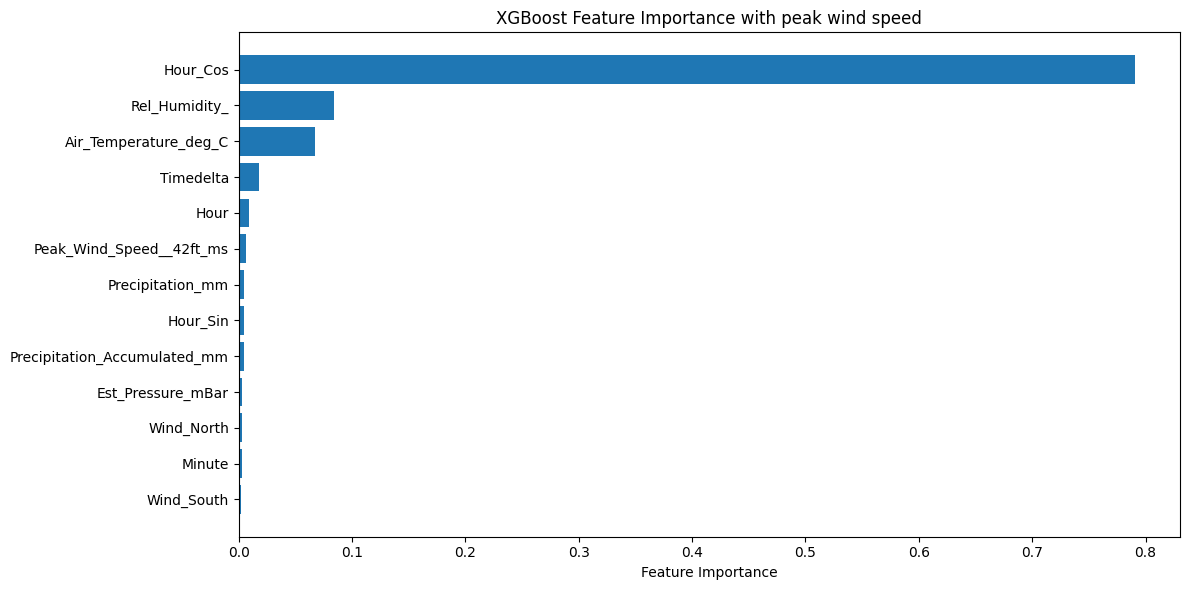

In [ ]:
#Usage
model, predictions, rmse, mae, r2 = train_and_evaluate_xgboost_fixed_params(
    X_train_scaled, X_test_scaled, y_train, y_test, wind_feature='peak'
)

In [ ]:
# 2. Rename columns (remove "[", "]", "<")
X_train_scaled.columns = X_train_scaled.columns.str.replace(r"[\[\]<>]", "", regex=True)
X_test_scaled.columns = X_test_scaled.columns.str.replace(r"[\[\]<>]", "", regex=True)

In [ ]:
# import optuna
# import numpy as np
# from xgboost import XGBRegressor
# from sklearn.model_selection import cross_val_score

# def objective(trial):
#     """Objective function for Bayesian Optimization"""

#     # Define the hyperparameter search space
#     params = {
#         'n_estimators': trial.suggest_int('n_estimators', 50, 300),
#         'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3),
#         'max_depth': trial.suggest_int('max_depth', 3, 15),
#         'subsample': trial.suggest_float('subsample', 0.6, 1.0),
#         'colsample_bytree': trial.suggest_float('colsample_bytree', 0.6, 1.0),
#         'gamma': trial.suggest_float('gamma', 0, 0.5),
#         'min_child_weight': trial.suggest_int('min_child_weight', 1, 10),
#         'random_state': 42,
#     }

#     # Build model and evaluate
#     model = XGBRegressor(**params)

#     # Example: 3-fold CV with negative RMSE
#     # Replace (X_train_scaled, y_train) with your actual data
#     scores = cross_val_score(model, X_train_scaled, y_train, cv=3, scoring='neg_root_mean_squared_error')
#     avg_rmse = -np.mean(scores)

#     return avg_rmse

# best_params_from_random_search = {
#     'n_estimators': 200,
#     'learning_rate': 0.1,
#     'max_depth': 5,
#     'subsample': 1.0,
#     'colsample_bytree': 1.0,
#     'gamma': 0,
#     'min_child_weight': 3,
#     # 'random_state': 42  # random_state can be specified in the objective or in the dict
# }

# study = optuna.create_study(direction='minimize')

# study.enqueue_trial(best_params_from_random_search)
# study.optimize(objective, n_trials=30)

In [ ]:
best_params

{'n_estimators': 145,
 'learning_rate': 0.028865734043167696,
 'max_depth': 4,
 'subsample': 0.616243941559358,
 'colsample_bytree': 0.7855897739890494,
 'gamma': 0.04390659465639186,
 'min_child_weight': 7}

In [ ]:
# from xgboost import XGBRegressor
# from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
# import numpy as np

# # 1. Get the best parameters from the study
# best_params = study.best_params
# print("Best parameters:", best_params)

# # 2. Create and train the model with these best params
# model = XGBRegressor(**best_params)
# model.fit(X_train_scaled, y_train)

# # 3. Make predictions
# predictions = model.predict(X_test_scaled)

# # 4. Evaluate
# mse = mean_squared_error(y_test, predictions)
# rmse = np.sqrt(mse)
# mae = mean_absolute_error(y_test, predictions)
# r2 = r2_score(y_test, predictions)

# # Normalized MSE (range-based)
# data_range = y_test.max() - y_test.min()
# nmse = mse / (data_range ** 2)

# print(f"\nBayesian-Optimized XGB Model Performance:")
# print(f"RMSE  : {rmse:.2f}")
# print(f"MAE   : {mae:.2f}")
# print(f"R^2   : {r2:.4f}")
# print(f"NMSE  : {nmse:.4f}")

Best parameters: {'n_estimators': 145, 'learning_rate': 0.028865734043167696, 'max_depth': 4, 'subsample': 0.616243941559358, 'colsample_bytree': 0.7855897739890494, 'gamma': 0.04390659465639186, 'min_child_weight': 7}

Bayesian-Optimized XGB Model Performance:
RMSE  : 123.40
MAE   : 82.51
R^2   : 0.7917
NMSE  : 0.0098


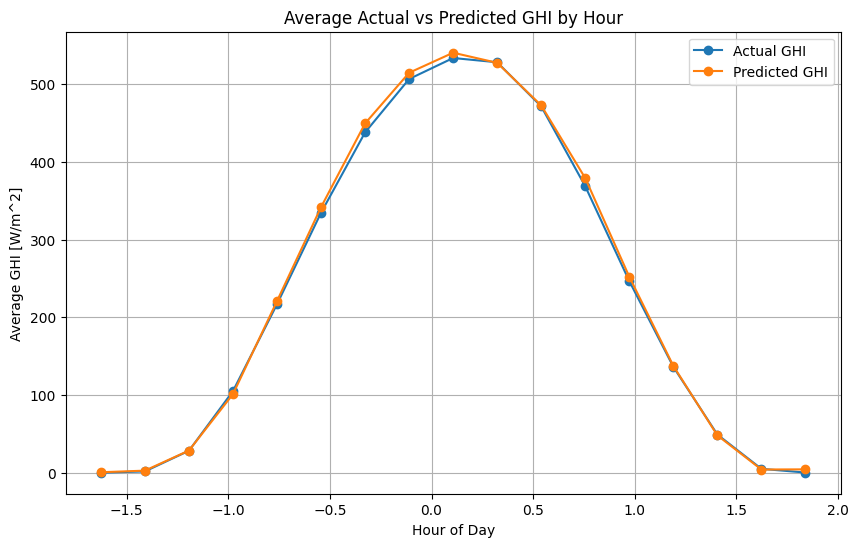

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

def plot_average_ghi_by_hour(X_test, y_test, predictions):
    """
    Plots the average actual vs. predicted GHI by hour of day.
    Assumes X_test has a column 'Hour' or similar that indicates the hour of the day.
    """

    # 1. Combine actual GHI, predicted GHI, and hour info
    #    (Replace 'Hour' with the correct column name if you used something else.)
    results_df = pd.DataFrame({
        'Hour': X_test['Hour'],       # or whichever column represents the hour
        'Actual_GHI': y_test,
        'Predicted_GHI': predictions
    })

    # 2. Group by 'Hour' and compute mean
    grouped = results_df.groupby('Hour', as_index=True)[['Actual_GHI', 'Predicted_GHI']].mean()

    # 3. Plot
    plt.figure(figsize=(10, 6))
    plt.plot(grouped.index, grouped['Actual_GHI'], label='Actual GHI', marker='o')
    plt.plot(grouped.index, grouped['Predicted_GHI'], label='Predicted GHI', marker='o')
    plt.title('Average Actual vs Predicted GHI by Hour')
    plt.xlabel('Hour of Day')
    plt.ylabel('Average GHI [W/m^2]')
    plt.legend()
    plt.grid(True)
    plt.show()

plot_average_ghi_by_hour(X_test_scaled, y_test, predictions)

In [ ]:
df = df.drop(columns=['Datetime'])
df_test = df.loc[X_test_scaled.index].copy()
# Add actual and predicted GHI columns
df_test['Actual_GHI'] = y_test.values
df_test['Predicted_GHI'] = predictions

In [ ]:
# import matplotlib.pyplot as plt

# def plot_ghi_finer_interval(
#     df,
#     date_col='DATE (MM/DD/YYYY)',
#     hour_col='Hour',
#     minute_col='Minute',
#     actual_col='Actual_GHI',
#     pred_col='Predicted_GHI',
#     freq='15T'
# ):
#     """
#     1) Create/overwrite 'Datetime' column from date/hour/minute.
#     2) Resample at a finer interval (e.g., 15 min) and plot Actual vs. Predicted GHI.
#     """

#     # --- If 'Datetime' exists as an index, reset it ---
#     if 'Datetime' in df.index.names:
#         df.reset_index(drop=False, inplace=True)

#     # --- Create/Overwrite the 'Datetime' column ---
#     df['Datetime'] = pd.to_datetime(df[date_col], format='%m/%d/%Y', errors='coerce')
#     df['Datetime'] += pd.to_timedelta(df[hour_col], unit='h')
#     df['Datetime'] += pd.to_timedelta(df[minute_col], unit='m')

#     # --- Sort and set index ---
#     df.sort_values('Datetime', inplace=True)
#     df.set_index('Datetime', inplace=True)

#     # --- Resample to a finer time interval (e.g., 15 minutes) ---
#     df_resampled = df[[actual_col, pred_col]].resample(freq).mean()

#     # --- Plot ---
#     plt.figure(figsize=(10, 6))
#     plt.plot(df_resampled.index, df_resampled[actual_col], marker='o', label='Actual GHI')
#     plt.plot(df_resampled.index, df_resampled[pred_col], marker='o', label='Predicted GHI')
#     plt.title(f'Actual vs. Predicted GHI (Resampled Every {freq})')
#     plt.xlabel('Datetime')
#     plt.ylabel('GHI [W/m^2]')
#     plt.legend()
#     plt.grid(True)
#     plt.show()

#     # --- Reset index if you want df returned to original state ---
#     df.reset_index(drop=False, inplace=True)



In [ ]:
# # After you have df_test with 'Actual_GHI' and 'Predicted_GHI':
# plot_ghi_finer_interval(df_test,
#     date_col='DATE (MM/DD/YYYY)',
#     hour_col='Hour',
#     minute_col='Minute',
#     actual_col='Actual_GHI',
#     pred_col='Predicted_GHI',
#     freq='15T'
# )

In [ ]:


def add_datetime_and_plot_bell_curve(
    df,
    date_col='DATE (MM/DD/YYYY)',
    hour_col='Hour',
    minute_col='Minute',
    actual_col='Global Horizontal [W/m^2]',
    pred_col='Predicted_GHI'
):
    """
    1) Creates a new 'Datetime' column from date, hour, and minute.
    2) Groups by hour to plot a daily 'bell curve' of Actual vs. Predicted GHI.
    """

    # --- 1. Create 'Datetime' column ---
    df['Datetime'] = pd.to_datetime(df[date_col], format='%m/%d/%Y', errors='coerce')
    df['Datetime'] += pd.to_timedelta(df[hour_col], unit='h')
    df['Datetime'] += pd.to_timedelta(df[minute_col], unit='m')

    # --- 2. Extract the hour of day ---
    df['HourOfDay'] = df['Datetime'].dt.hour

    # --- 3. Group by hour and take the average of actual and predicted GHI ---
    grouped = df.groupby('HourOfDay', as_index=True)[[actual_col, pred_col]].mean()

    # --- 4. Plot the bell curve of Actual vs. Predicted GHI ---
    plt.figure(figsize=(10, 6))
    plt.plot(grouped.index, grouped[actual_col], marker='o', label='Average Actual GHI')
    plt.plot(grouped.index, grouped[pred_col], marker='o', label='Average Predicted GHI')
    plt.title('Average Daily  of Actual vs. Predicted GHI')
    plt.xlabel('Hour of Day')
    plt.ylabel('GHI [W/m^2]')
    plt.xticks(range(0, 24))  # Ticks for each hour from 0 to 23
    plt.legend()
    plt.grid(True)
    plt.show()



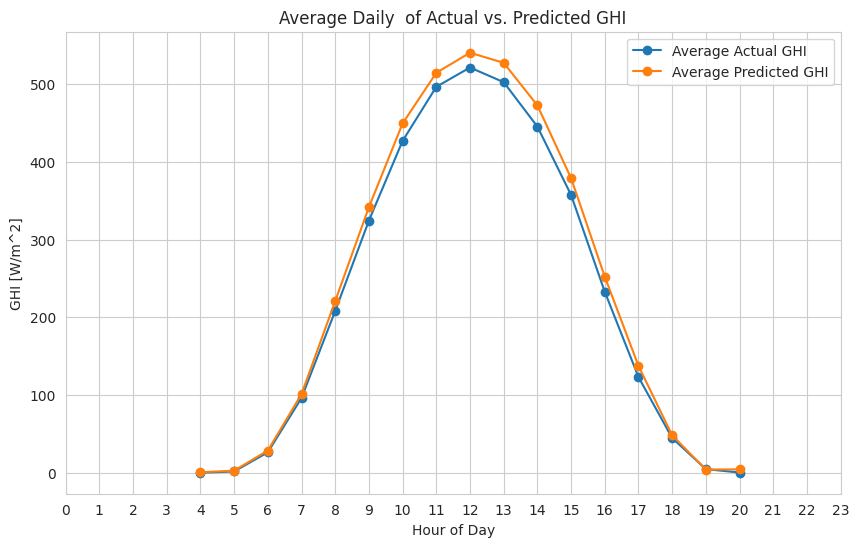

In [ ]:
df_merged = pd.merge(
    df,
    df_test[['DATE (MM/DD/YYYY)', 'Hour', 'Minute', 'Predicted_GHI']],
    on=['DATE (MM/DD/YYYY)', 'Hour', 'Minute'],
    how='left'
)

add_datetime_and_plot_bell_curve(
    df_merged,
    date_col='DATE (MM/DD/YYYY)',
    hour_col='Hour',
    minute_col='Minute',
    actual_col='Global Horizontal [W/m^2]',
    pred_col='Predicted_GHI'
)